In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score as auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

from func import split_data, rm_high_corr_feat

# Model 1 - Агрегированные данные по командам

In [2]:
df = pd.read_csv('../prepare data/data/df_1.csv')

In [7]:
df

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,team_1_hue,_accurate_back_zone_pass_team_1,_accurate_chipped_pass_team_1,_accurate_corners_intobox_team_1,_accurate_cross_team_1,...,_total_through_ball_team_2,_total_throws_team_2,_total_yel_card_team_2,_touches_team_2,_touches_in_opp_box_team_2,_unsuccessful_touch_team_2,_wins_team_2,_won_contest_team_2,_won_corners_team_2,_won_tackle_team_2
0,18,2023,West Ham United,Manchester United,London Stadium,1,5829.5,648.75,50.75,169.5,...,70.75,755.5,72.50,26813.75,996.5,532.5,19.5,387.5,198.5,350.5
1,35,2022,West Ham United,Manchester United,London Stadium,1,5829.5,648.75,50.75,169.5,...,70.75,755.5,72.50,26813.75,996.5,532.5,19.5,387.5,198.5,350.5
2,5,2021,West Ham United,Manchester United,London Stadium,0,5829.5,648.75,50.75,169.5,...,70.75,755.5,72.50,26813.75,996.5,532.5,19.5,387.5,198.5,350.5
3,11,2020,West Ham United,Manchester United,London Stadium,0,5829.5,648.75,50.75,169.5,...,70.75,755.5,72.50,26813.75,996.5,532.5,19.5,387.5,198.5,350.5
4,6,2019,West Ham United,Manchester United,London Stadium,1,5829.5,648.75,50.75,169.5,...,70.75,755.5,72.50,26813.75,996.5,532.5,19.5,387.5,198.5,350.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,36,2021,Norwich City,West Ham United,Carrow Road,0,7369.0,614.50,47.00,112.0,...,30.75,762.0,50.25,22358.00,817.0,491.5,14.0,312.5,191.5,333.5
1524,35,2019,Norwich City,West Ham United,Carrow Road,0,7369.0,614.50,47.00,112.0,...,30.75,762.0,50.25,22358.00,817.0,491.5,14.0,312.5,191.5,333.5
1525,20,2021,Watford,West Ham United,Vicarage Road,0,4920.0,620.50,39.00,148.0,...,30.75,762.0,50.25,22358.00,817.0,491.5,14.0,312.5,191.5,333.5
1526,3,2019,Watford,West Ham United,Vicarage Road,0,4920.0,620.50,39.00,148.0,...,30.75,762.0,50.25,22358.00,817.0,491.5,14.0,312.5,191.5,333.5


In [8]:
df['teams_team_1_name'].unique()

array(['West Ham United', 'Liverpool', 'Fulham', 'Tottenham Hotspur',
       'Nottingham Forest', 'Aston Villa', 'Crystal Palace',
       'Manchester City', 'Wolverhampton Wanderers', 'Arsenal', 'Everton',
       'Brentford', 'Chelsea', 'Burnley', 'Bournemouth',
       'Sheffield United', 'Newcastle United', 'Leeds United',
       'Leicester City', 'Southampton', 'Norwich City', 'Watford',
       'West Bromwich Albion', 'Manchester United'], dtype=object)

In [22]:
train = df.iloc[50:, :]
val = df.iloc[:50, :]

y_train = train['team_1_hue']
x_train = train.drop('team_1_hue', axis=1)

y_val = val['team_1_hue']
x_val = val.drop('team_1_hue', axis=1)

In [23]:
cat = ['gameweek_gameweek',	'gameweek_compSeason_label', 'teams_team_1_name', 'teams_team_2_name', 'ground_name']

In [24]:
model_1 = CatBoostClassifier()


In [25]:
model_1.fit(x_train, y_train, cat_features=cat, verbose=False)


In [26]:
pred = model_1.predict(x_val)
pred_proba = model_1.predict_proba(x_val)
y_val = y_val.to_numpy().reshape(-1, 1)

In [27]:
pred = np.concatenate((y_val, pred, pred_proba), axis=1)
df_pred = pd.DataFrame(pred, columns=['true', 'pred', '0_prob', '1_prob', '2_prob'])

In [28]:
df_pred['error'] = np.where(df_pred['true']==df_pred['pred'], 0, 1)

df_pred.head()

,true,pred,0_prob,1_prob,2_prob,error
0,1.0,0.0,0.390643,0.389590,0.219766,1
1,1.0,1.0,0.338174,0.542523,0.119303,0
2,0.0,0.0,0.659138,0.260656,0.080206,0
3,0.0,0.0,0.605124,0.273516,0.121360,0
4,1.0,0.0,0.487945,0.359279,0.152775,1


In [29]:
df_pred['error'].sum()

28

In [30]:
df_pred.shape

(50, 6)

In [31]:
accuracy_score(df_pred['true'], df_pred['pred'])

0.44

# Модели на датасетах с отбором признаков 

In [32]:
thrs = [i/100 for i in range(100, 45, -5)] # Список значений корреляций для удаления признаков

In [33]:
acc_score = []
for thr in tqdm(thrs):

    
    df_temp = rm_high_corr_feat(df, thr, 6)

    x_train, y_train, x_val, y_val = split_data(df_temp, 'gameweek_compSeason_label', 'team_1_hue')

    model_temp = CatBoostClassifier(iterations=3000)
    model_temp.fit(x_train, y_train, cat_features=cat, verbose=False)

    pred_temp = model_temp.predict(x_val)

    score_temp = accuracy_score(pred_temp, y_val)

    print(f'thr: {thr}\naccuracy: {np.round(score_temp, 3)}\nпризнаков: {df_temp.shape[1]}\n')

    acc_score.append(score_temp)


  9%|▉         | 1/11 [00:31<05:17, 31.79s/it]

thr: 1.0
accuracy: 0.569
признаков: 426



 18%|█▊        | 2/11 [00:57<04:11, 27.94s/it]

thr: 0.95
accuracy: 0.575
признаков: 310



 27%|██▋       | 3/11 [01:13<03:01, 22.67s/it]

thr: 0.9
accuracy: 0.569
признаков: 250



 36%|███▋      | 4/11 [01:27<02:15, 19.42s/it]

thr: 0.85
accuracy: 0.544
признаков: 194



 45%|████▌     | 5/11 [01:40<01:42, 17.09s/it]

thr: 0.8
accuracy: 0.569
признаков: 152



 55%|█████▍    | 6/11 [01:51<01:14, 14.87s/it]

thr: 0.75
accuracy: 0.544
признаков: 124



 64%|██████▎   | 7/11 [02:01<00:53, 13.41s/it]

thr: 0.7
accuracy: 0.55
признаков: 92



 73%|███████▎  | 8/11 [02:11<00:36, 12.22s/it]

thr: 0.65
accuracy: 0.581
признаков: 75



 82%|████████▏ | 9/11 [02:19<00:21, 10.80s/it]

thr: 0.6
accuracy: 0.544
признаков: 58



 91%|█████████ | 10/11 [02:26<00:09,  9.72s/it]

thr: 0.55
accuracy: 0.556
признаков: 46



100%|██████████| 11/11 [02:33<00:00, 13.96s/it]

thr: 0.5
accuracy: 0.525
признаков: 36



<Axes: >

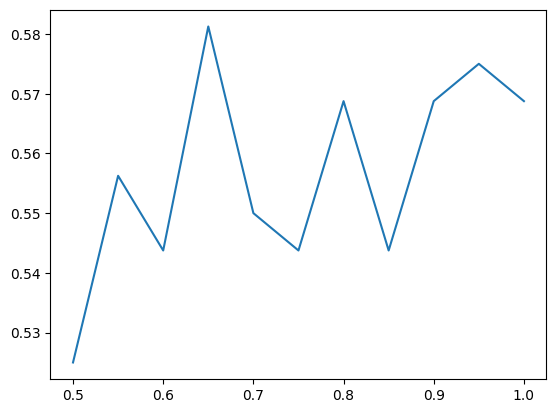

In [34]:
sns.lineplot(x=thrs, y=acc_score)

Возьмем датасет с отобранными признаки, где корреляция не выше 0.6 между признаками

In [35]:
df_temp = rm_high_corr_feat(df, 0.6, 6)

x_train, y_train, x_val, y_val = split_data(df_temp, 'gameweek_compSeason_label', 'team_1_hue')

In [39]:
grid = {'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 12]}

In [41]:
score = 0
for depth in grid['depth']:
    for l2 in grid['l2_leaf_reg']:
        

        model_temp = CatBoostClassifier(iterations=3000, depth=depth, l2_leaf_reg=l2)
        model_temp.fit(x_train, y_train, cat_features=cat, verbose=False)

        pred_temp = model_temp.predict(x_val)

        score_temp = accuracy_score(pred_temp, y_val)

        if score_temp > score:            
            score = score_temp
            print(f'accuracy: {np.round(score_temp, 3)}\ndepth: {depth}\nl2_leaf_reg: {l2}\n')

        #print(f'accuracy: {np.round(score_temp, 3)}\ndepth: {depth}\nl2_leaf_reg: {l2}\n')


accuracy: 0.544
depth: 2
l2_leaf_reg: 1

accuracy: 0.556
depth: 2
l2_leaf_reg: 7

accuracy: 0.569
depth: 2
l2_leaf_reg: 9

accuracy: 0.575
depth: 6
l2_leaf_reg: 3

